In [3]:
import pandas as pd
import numpy as np
import os
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

In [4]:
def group_consecutive_predictions_birdnet(predictions_df):
    grouped_predictions = []
    current_group = []
    last_end = None
    for _, row in predictions_df.iterrows():
        if current_group and (row['Start (s)'] != last_end or row['Scientific name'] != current_group[-1]['Scientific name']):
            # New group starts here
            grouped_predictions.append(current_group)
            current_group = []
        current_group.append(row)
        last_end = row['End (s)']
    if current_group:  # Add last group
        grouped_predictions.append(current_group)
    # Combine groups in unique predictions
    combined_predictions = []
    for group in grouped_predictions:
        combined_prediction = {
            'Start (s)': group[0]['Start (s)'],
            'End (s)': group[-1]['End (s)'],
            'Scientific name': group[0]['Scientific name'],
            'Confidence': max(item['Confidence'] for item in group)  # conf = max confidence in group
        }
        combined_predictions.append(combined_prediction)
    return combined_predictions

def group_consecutive_annotations_gt(annotations_df):
    annotations_df.sort_values(by=['path', 'specie', 'start_time'], inplace=True)
    grouped_predictions = []
    current_group = []
    last_end = None
    last_path = None
    last_specie = None

    for _, row in annotations_df.iterrows():
        if current_group and (row['path'] != last_path or row['specie'] != last_specie or row['start_time'] - last_end >= 2):
            # New group starts here
            grouped_predictions.append(current_group)
            current_group = []
        current_group.append(row)
        last_end = row['end_time']
        last_path = row['path']
        last_specie = row['specie']
    if current_group:  # Add last group
        grouped_predictions.append(current_group)

    # Combine groups into unique predictions
    combined_annotations = []
    for group in grouped_predictions:
        combined_prediction = {
            'path': group[0]['path'],
            'start_time': group[0]['start_time'],
            'end_time': group[-1]['end_time'],
            'specie': group[0]['specie'],
        }
        combined_annotations.append(combined_prediction)
    
    return combined_annotations

In [5]:
# Function to calculate the IoU
def calculate_iou(interval1, interval2):
    start_max = max(interval1[0], interval2[0])
    end_min = min(interval1[1], interval2[1])
    intersection = max(0, end_min - start_max)
    union = (interval1[1] - interval1[0]) + (interval2[1] - interval2[0]) - intersection
    return intersection / union if union != 0 else 0

In [6]:
# Ground Truth CSV
PATH = "../Data/"
gt_csv = PATH + "Dataset/CSVs/test_with_bg.csv"

# Read the Ground Truth CSV
gt_df = pd.read_csv(gt_csv)
print("Número de Ground Truths: ", len(gt_df))

Número de Ground Truths:  542


In [7]:
gt_df = group_consecutive_annotations_gt(gt_df)
gt_df = pd.DataFrame(gt_df)  # Convert list dict to DataFrame
print("Número de Ground Truths agrupados: ", len(gt_df))

Número de Ground Truths agrupados:  403


In [8]:
# Función para convertir la puntuación de confianza en puntuación logit
def confidence_to_logit(confidence_score):
    # Evitar división por cero y logaritmo de cero
    confidence_score = np.clip(confidence_score, 1e-10, 1 - 1e-10)
    logit_score = np.log(confidence_score / (1 - confidence_score))
    return logit_score

# Función para convertir la puntuación logit en probabilidad
def logit_to_probability(logit_score):
    probability = 1 / (1 + np.exp(-logit_score))
    return probability

# Función para convertir la puntuación de confianza en probabilidad
def confidence_to_probability(confidence_score, sensitivity=1.0):
    probability = 1 / (1 + np.exp(-confidence_score / sensitivity))
    return probability

In [23]:
def evaluate_predictions(gt_annotations_file, experiment, iou_threshold, model_name="", probability_correct_prediction=None):
    # Leer el archivo CSV con anotaciones
    annotations_df = pd.read_csv(gt_annotations_file)
    annotations_df = group_consecutive_annotations_gt(annotations_df)
    annotations_df = pd.DataFrame(annotations_df)  # Convert list dict to DataFrame

    # Listar archivos de predicciones
    prediction_files = os.listdir(f'../BirdNET/Audios/{experiment}')
    number_of_predictions = len(prediction_files)
    print(f"Number of predictions: {number_of_predictions}")
    print(f"Number of annotations: {len(annotations_df)}")

    # Initialize an empty list to store prediction data
    predictions_data = []

    # Convert prediction files into a list of dictionaries with basename, start_time, end_time, and score
    for prediction in prediction_files:
        parts = prediction.split('_')
        basename = '_'.join(parts[:3])
        start_time = parts[-3]
        end_time = parts[-2]
        score = float(parts[-1].split('.W')[0])

        predictions_data.append({'basename': basename, 'start_time': start_time, 'end_time': end_time, 'score': score})

    # Convert the list of dictionaries into a DataFrame
    predictions_df = pd.DataFrame(predictions_data, columns=['basename', 'start_time', 'end_time', 'score'])

    # Inicializar contadores y listas
    TP = 0
    FP = 0
    FN = 0
    TN = 0
    fp_predictions = []
    fn_predictions = []

    # change annotations_df path to basename
    annotations_df['basename'] = annotations_df['path'].apply(lambda x: x.split("/")[-1].split(".")[0])

    # Identificar anotaciones "No audio"
    no_audio_annotations = annotations_df[annotations_df['specie'] == 'No audio']

    # Evaluar predicciones en segmentos "No audio"
    if not no_audio_annotations.empty:
        for _, row in no_audio_annotations.iterrows():
            if row['basename'] in predictions_df['basename'].values:
                FP += len(predictions_df[predictions_df['basename'] == row['basename']])
                for _, prediction in predictions_df[predictions_df['basename'] == row['basename']].iterrows():
                    filename = str(prediction['basename'] + "_" + str(prediction["start_time"]) + "_" + str(prediction["end_time"]))
                    fp_predictions.append({'file': filename, 'reason': 'Predicted audio in no-audio segment'})
            else:
                TN += len(predictions_df[predictions_df['basename'] == row['basename']])

    # Eliminar anotaciones "No audio" del DataFrame
    annotations_df = annotations_df[annotations_df['specie'] != 'No audio']

    # Evaluar predicciones
    correct_predictions = []
    for _, prediction in predictions_df.iterrows():
        matched = False
        for _, row in annotations_df.iterrows():
            annotation_interval = [row['start_time'], row['end_time']]
            prediction_interval = [float(prediction['start_time']), float(prediction['end_time'])]
            iou = calculate_iou(prediction_interval, annotation_interval)
            if iou >= iou_threshold and prediction['basename'] == row['basename']:
                TP += 1
                correct_predictions.append({'score': prediction['score'], 'correct': 1})
                matched = True
                break
        if not matched:
            FN += 1
            correct_predictions.append({'score': prediction['score'], 'correct': 0})
            filename = str(prediction['basename'] + "_" + str(prediction["start_time"]) + "_" + str(prediction["end_time"]))
            fn_predictions.append({'file': filename, 'reason': 'No matching annotation found'})

    # Convertir listas a DataFrames
    fp_df = pd.DataFrame(fp_predictions)
    fn_df = pd.DataFrame(fn_predictions)
    correct_predictions_df = pd.DataFrame(correct_predictions)

    # Ajustar modelo de regresión logística
    X = correct_predictions_df[['score']]
    y = correct_predictions_df['correct']
    log_reg = LogisticRegression()
    log_reg.fit(X, y)

    # Predicciones de probabilidad
    X_test = np.linspace(X.min(), X.max(), 300).reshape(-1, 1)
    y_prob = log_reg.predict_proba(X_test)[:, 1]

    # Graficar
    plt.figure(figsize=(10, 6))
    plt.scatter(X, y, color='black', zorder=20)
    plt.plot(X_test, y_prob, color='blue', linewidth=3)

    # Plot red line if probability_correct_prediction is specified
    if probability_correct_prediction is not None:
        # Solve for score where the model predicts the specified probability
        score_at_probability = (np.log(probability_correct_prediction / (1 - probability_correct_prediction)) - log_reg.intercept_) / log_reg.coef_[0]
        plt.axvline(x=score_at_probability, color='red', linestyle='--')  # Vertical line
        plt.axhline(y=probability_correct_prediction, color='red', linestyle='--')  # Horizontal line
        plt.text(score_at_probability, 0.5, f'{score_at_probability[0]:.2f}', color='red')
    

    plt.xlabel('Prediction Score')
    plt.ylabel('Probability of Correct Prediction')
    plt.title(f'Logistic Regression Model\n{model_name}')
    plt.show()

Number of predictions: 406
Number of annotations: 403


/home/gruncrow/anaconda3/envs/BIRDeep/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


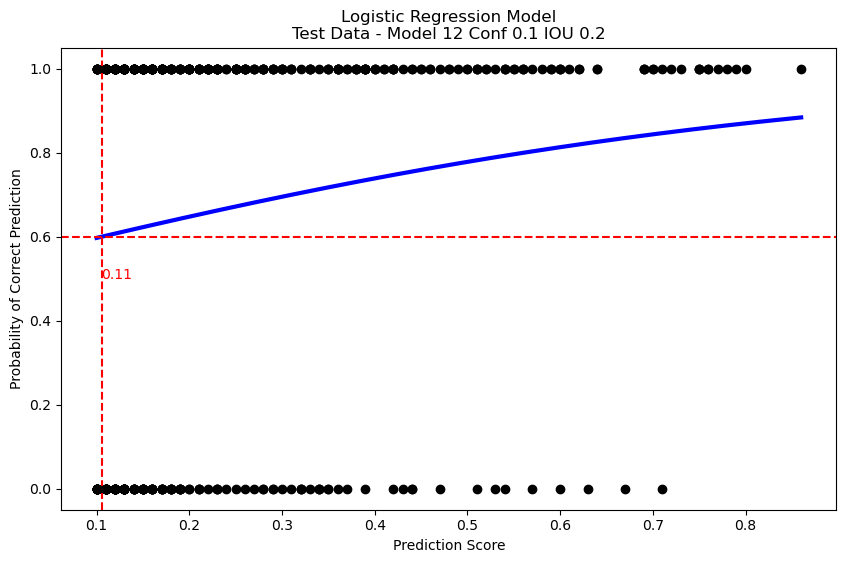

In [32]:
iou_threshold = 0.1
experiment = "predict_conf01_iou02"
gt_annotations_file = f'../BirdNET/Dataset/test_with_bg.csv'
model_name = "Test Data - Model 12 Conf 0.1 IOU 0.2"
probability_correct_prediction = 0.6

evaluate_predictions(gt_annotations_file, experiment, iou_threshold, model_name, probability_correct_prediction)

Number of predictions: 25896
Number of annotations: 492


/home/gruncrow/anaconda3/envs/BIRDeep/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


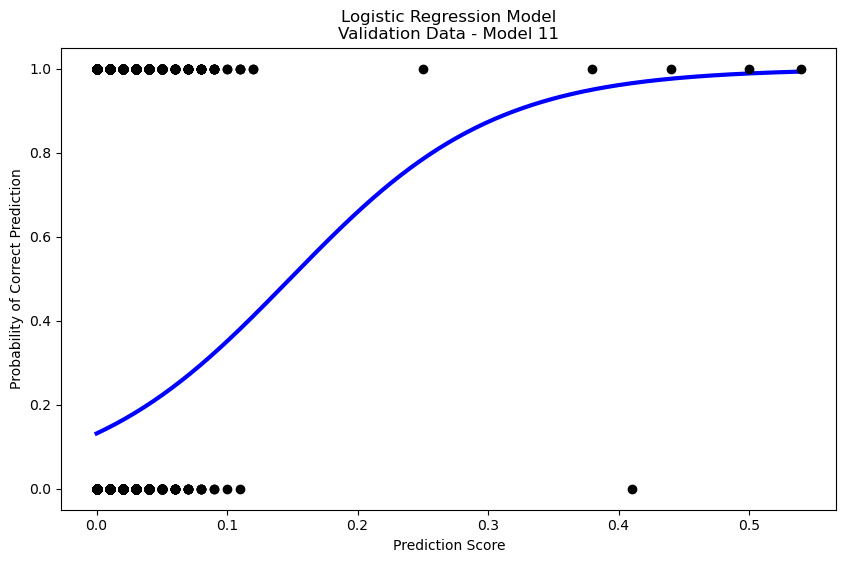

In [33]:
iou_threshold = 0.1
experiment = "predict__val_model11_conf0"
gt_annotations_file = f'../BirdNET/Dataset/validation_with_augmented_bg.csv'
model_name = "Validation Data - Model 11"
probability_correct_prediction = None

evaluate_predictions(gt_annotations_file, experiment, iou_threshold, model_name, probability_correct_prediction)

Number of predictions: 24433
Number of annotations: 492


/home/gruncrow/anaconda3/envs/BIRDeep/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


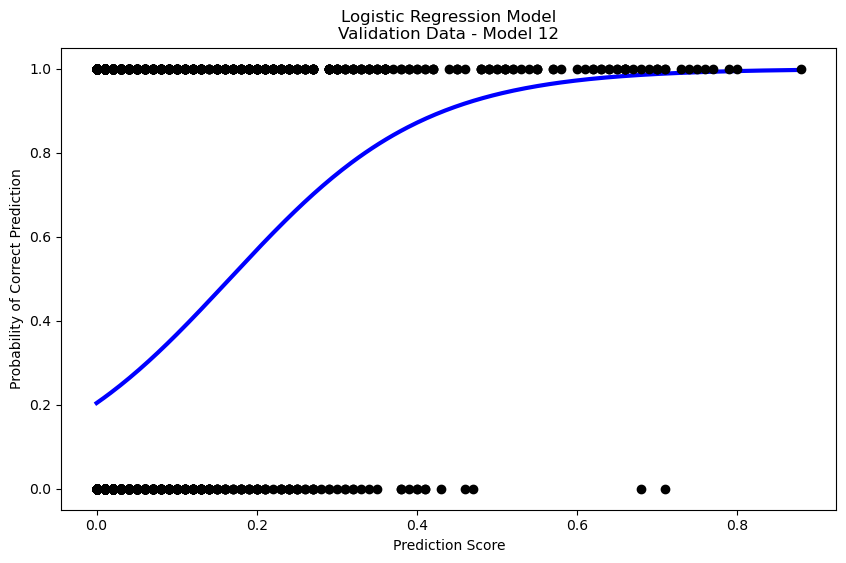

In [28]:
iou_threshold = 0.1
experiment = "predict__val_model12_conf0"
gt_annotations_file = f'../BirdNET/Dataset/validation_with_augmented_bg.csv'
model_name = "Validation Data - Model 12"
probability_correct_prediction = None

evaluate_predictions(gt_annotations_file, experiment, iou_threshold, model_name, probability_correct_prediction)

Number of predictions: 14
Number of annotations: 492


/home/gruncrow/anaconda3/envs/BIRDeep/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


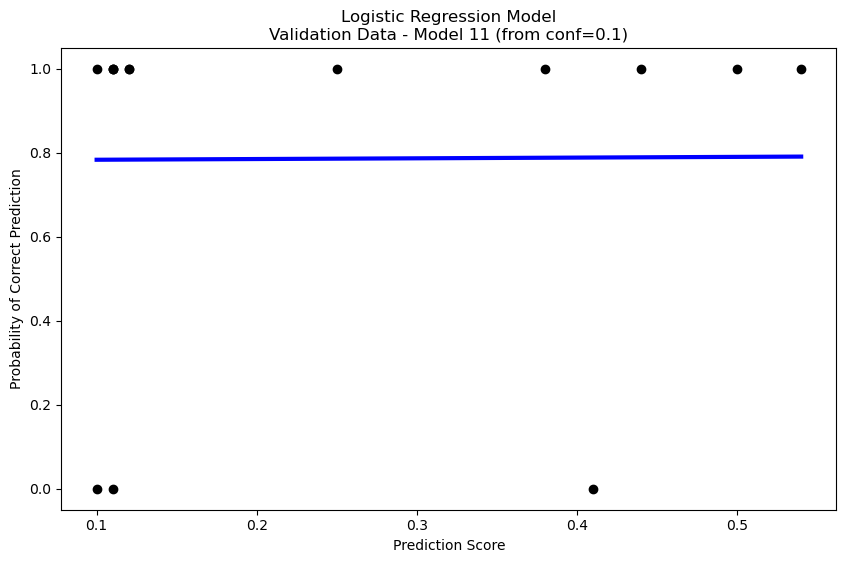

In [34]:
iou_threshold = 0.1
experiment = "predict__val_model11_conf01"
gt_annotations_file = f'../BirdNET/Dataset/validation_with_augmented_bg.csv'
model_name = "Validation Data - Model 11 (from conf=0.1)"
probability_correct_prediction = None

evaluate_predictions(gt_annotations_file, experiment, iou_threshold, model_name, probability_correct_prediction)

Number of predictions: 447
Number of annotations: 492


/home/gruncrow/anaconda3/envs/BIRDeep/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


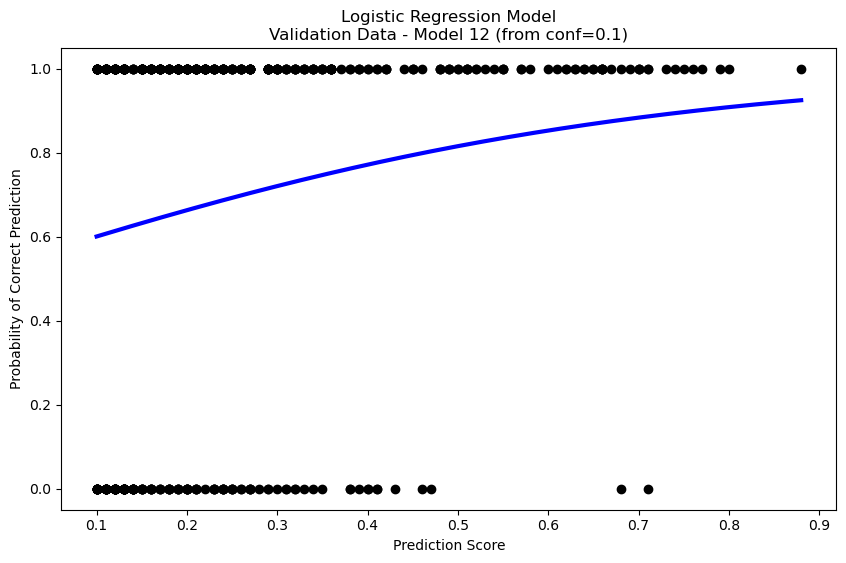

In [31]:
iou_threshold = 0.1
experiment = "predict__val_model12_conf01"
gt_annotations_file = f'../BirdNET/Dataset/validation_with_augmented_bg.csv'
model_name = "Validation Data - Model 12 (from conf=0.1)"
probability_correct_prediction = None

evaluate_predictions(gt_annotations_file, experiment, iou_threshold, model_name, probability_correct_prediction)

# Probabilities

Number of predictions: 406
Number of annotations: 403


/home/gruncrow/anaconda3/envs/BIRDeep/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


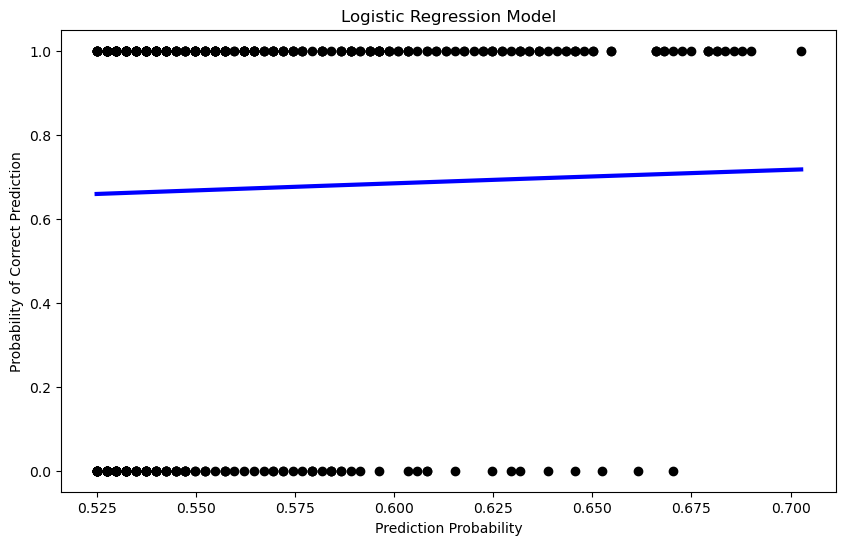

In [16]:
# Umbral para considerar una predicción como correcta
iou_threshold = 0.1
experiment = "predict_conf01_iou02"

# Leer el archivo CSV con anotaciones
annotations_df = pd.read_csv('../BirdNET/Dataset/test_with_bg.csv')
annotations_df = group_consecutive_annotations_gt(annotations_df)
annotations_df = pd.DataFrame(gt_df)  # Convert list dict to DataFrame

# Listar archivos de predicciones
prediction_files = os.listdir(f'../BirdNET/Audios/{experiment}')
number_of_predictions = len(prediction_files)
print(f"Number of predictions: {number_of_predictions}")
print(f"Number of annotations: {len(annotations_df)}")

# Initialize an empty list to store prediction data
predictions_data = []

# Convert prediction files into a list of dictionaries with basename, start_time, end_time, and score
for prediction in prediction_files:
    parts = prediction.split('_')
    basename = '_'.join(parts[:3])
    start_time = parts[-3]
    end_time = parts[-2]
    score = float(parts[-1].split('.W')[0])

    predictions_data.append({'basename': basename, 'start_time': start_time, 'end_time': end_time, 'score': score})

# Convert the list of dictionaries into a DataFrame
predictions_df = pd.DataFrame(predictions_data, columns=['basename', 'start_time', 'end_time', 'score'])

# Convertir las puntuaciones de confianza a puntuaciones logit
predictions_df['probability'] = predictions_df['score'].apply(lambda x: confidence_to_probability(x, sensitivity=1))

# Inicializar contadores y listas
TP = 0
FP = 0
FN = 0
TN = 0
fp_predictions = []
fn_predictions = []

# change annotations_df path to basename
annotations_df['basename'] = annotations_df['path'].apply(lambda x: x.split("/")[-1].split(".")[0])

# Identificar anotaciones "No audio"
no_audio_annotations = annotations_df[annotations_df['specie'] == 'No audio']

# Evaluar predicciones en segmentos "No audio"
if not no_audio_annotations.empty:
    for _, row in no_audio_annotations.iterrows():
        if row['basename'] in predictions_df['basename'].values:
            FP += len(predictions_df[predictions_df['basename'] == row['basename']])
            for _, prediction in predictions_df[predictions_df['basename'] == row['basename']].iterrows():
                filename = str(prediction['basename'] + "_" + str(prediction["start_time"]) + "_" + str(prediction["end_time"]))
                fp_predictions.append({'file': filename, 'reason': 'Predicted audio in no-audio segment'})
        else:
            TN += len(predictions_df[predictions_df['basename'] == row['basename']])

# Eliminar anotaciones "No audio" del DataFrame
annotations_df = annotations_df[annotations_df['specie'] != 'No audio']

# Evaluar predicciones
correct_predictions = []
for _, prediction in predictions_df.iterrows():
    matched = False
    for _, row in annotations_df.iterrows():
        annotation_interval = [row['start_time'], row['end_time']]
        prediction_interval = [float(prediction['start_time']), float(prediction['end_time'])]
        iou = calculate_iou(prediction_interval, annotation_interval)
        if iou >= iou_threshold and prediction['basename'] == row['basename']:
            TP += 1
            correct_predictions.append({'probability': prediction['probability'], 'correct': 1})
            matched = True
            break
    if not matched:
        FN += 1
        correct_predictions.append({'probability': prediction['probability'], 'correct': 0})
        filename = str(prediction['basename'] + "_" + str(prediction["start_time"]) + "_" + str(prediction["end_time"]))
        fn_predictions.append({'file': filename, 'reason': 'No matching annotation found'})

# Convertir listas a DataFrames
fp_df = pd.DataFrame(fp_predictions)
fn_df = pd.DataFrame(fn_predictions)
correct_predictions_df = pd.DataFrame(correct_predictions)

# Ajustar modelo de regresión logística
X = correct_predictions_df[['probability']]
y = correct_predictions_df['correct']
log_reg = LogisticRegression()
log_reg.fit(X, y)

# Predicciones de probabilidad
X_test = np.linspace(X.min(), X.max(), 300).reshape(-1, 1)
y_prob = log_reg.predict_proba(X_test)[:, 1]

# Graficar
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='black', zorder=20)
plt.plot(X_test, y_prob, color='blue', linewidth=3)
plt.xlabel('Prediction Probability')
plt.ylabel('Probability of Correct Prediction')
plt.title('Logistic Regression Model')
plt.show()